 # Quick comparison of PCN and BioPCN on MNIST

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch

from tqdm.notebook import tqdm
from functools import partial

from cpcn import LinearBioPCN, PCNetwork, load_mnist, Trainer

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# get train, validation, and test loaders for MNIST
dataset = load_mnist(n_validation=1000, device=device)

 ## Train PCN

In [3]:
n_batches = 3000
dims = [784, 5, 10]
it_inference = 50
lr_inference = 0.07
rho = 0.015
# rho = 0.0012

torch.manual_seed(123)

net = PCNetwork(
    dims,
    activation=lambda _: _,
    lr_inference=lr_inference,
    it_inference=it_inference,
    variances=1.0,
    constrained=True,
    rho=rho,
    bias=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.peek_validation(every=10)
trainer.set_classifier("linear")

trainer.set_optimizer(torch.optim.Adam, lr=0.003)
# trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99))

results = trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ### Show PCN learning curves

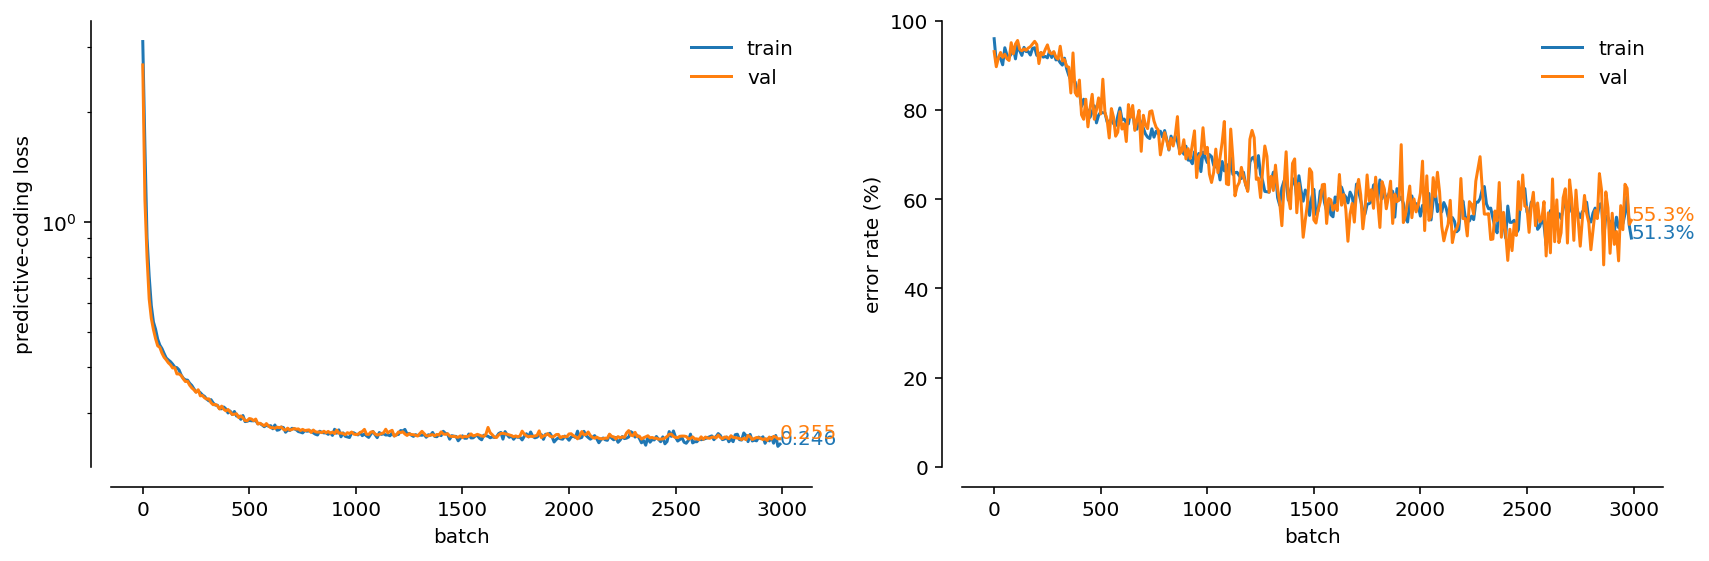

In [4]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.semilogy(results.train["batch"], results.train["pc_loss"], label="train")
    ax1.semilogy(
        results.validation["batch"], results.validation["pc_loss"], label="val"
    )
    ax1.set_xlabel("batch")
    ax1.set_ylabel("predictive-coding loss")
    ax1.legend(frameon=False)
    last_loss = results.train["pc_loss"][-1]
    ax1.annotate(f"{last_loss:.3f}", (results.train["batch"][-1], last_loss), c="C0")
    last_loss = results.validation["pc_loss"][-1]
    ax1.annotate(
        f"{last_loss:.3f}", (results.validation["batch"][-1], last_loss), c="C1"
    )

    ax2.plot(
        results.train["batch"], 100 * (1 - results.train["accuracy"]), label="train"
    )
    ax2.plot(
        results.validation["batch"],
        100 * (1 - results.validation["accuracy"]),
        label="val",
    )
    ax2.set_xlabel("batch")
    ax2.set_ylabel("error rate (%)")
    ax2.legend(frameon=False)
    last_acc = 100 * (1 - results.train["accuracy"][-1])
    ax2.annotate(f"{last_acc:.1f}%", (results.train["batch"][-1], last_acc), c="C0")
    last_acc = 100 * (1 - results.validation["accuracy"][-1])
    ax2.annotate(
        f"{last_acc:.1f}%", (results.validation["batch"][-1], last_acc), c="C1"
    )
    ax2.set_ylim(0, 100)

 ## Train BioPCN

In [5]:
z_it = 50
z_lr = 0.02

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)
biopcn_net = biopcn_net.to(device)

biopcn_trainer = Trainer(biopcn_net, dataset["train"], dataset["validation"])
biopcn_trainer.peek_validation(every=10)
biopcn_trainer.set_classifier("linear")

biopcn_trainer.set_optimizer(torch.optim.Adam, lr=0.004)
# biopcn_trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.997))

biopcn_results = biopcn_trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ### Show BioPCN learning curves

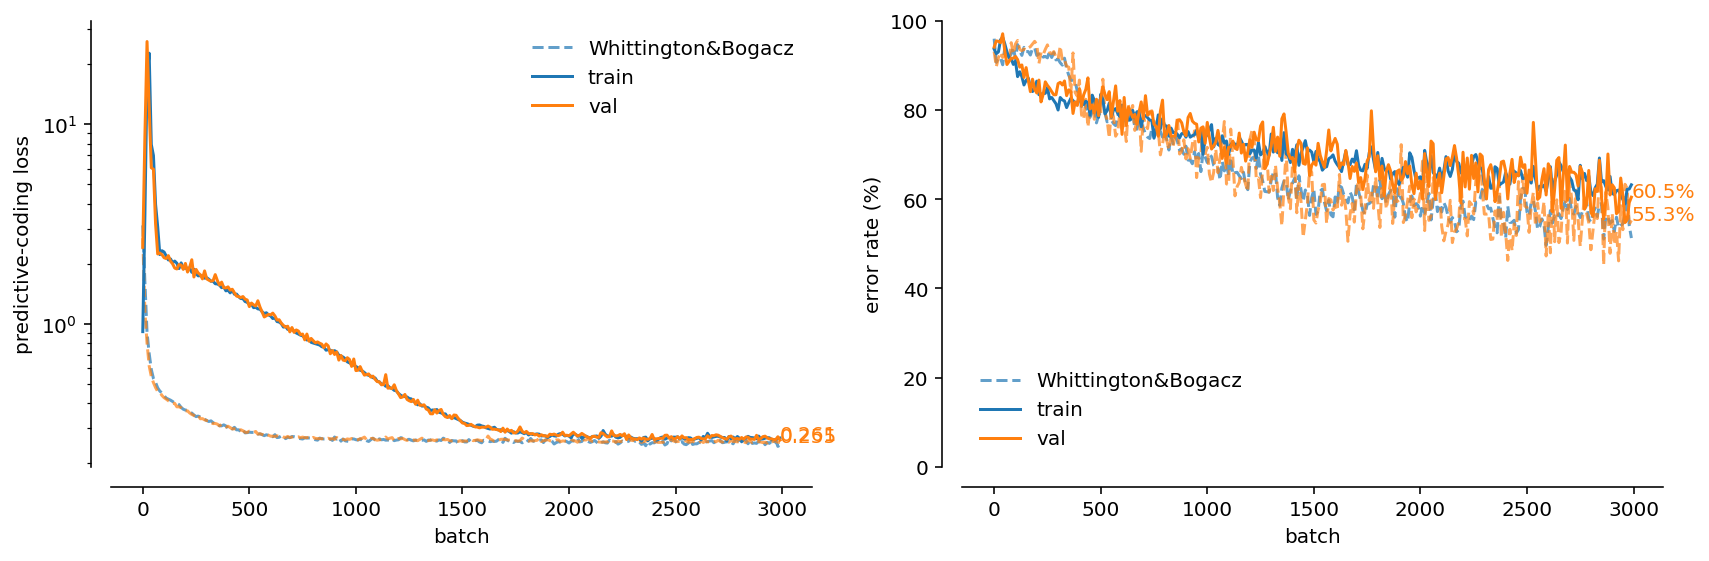

In [6]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.semilogy(
        results.train["batch"],
        results.train["pc_loss"],
        c="C0",
        ls="--",
        alpha=0.7,
        label="Whittington&Bogacz",
    )
    ax1.semilogy(
        results.validation["batch"],
        results.validation["pc_loss"],
        c="C1",
        ls="--",
        alpha=0.7,
    )

    ax1.semilogy(
        biopcn_results.train["batch"],
        biopcn_results.train["pc_loss"],
        c="C0",
        label="train",
    )
    ax1.semilogy(
        biopcn_results.validation["batch"],
        biopcn_results.validation["pc_loss"],
        c="C1",
        label="val",
    )

    last_loss = results.validation["pc_loss"][-1]
    ax1.annotate(
        f"{last_loss:.3f}", (results.validation["batch"][-1], last_loss), c="C1"
    )
    last_loss = biopcn_results.validation["pc_loss"][-1]
    ax1.annotate(
        f"{last_loss:.3f}", (results.validation["batch"][-1], last_loss), c="C1",
    )

    ax1.set_xlabel("batch")
    ax1.set_ylabel("predictive-coding loss")
    ax1.legend(frameon=False)

    ax2.plot(
        results.validation["batch"],
        100 * (1 - results.train["accuracy"]),
        c="C0",
        ls="--",
        alpha=0.7,
        label="Whittington&Bogacz",
    )
    ax2.plot(
        results.validation["batch"],
        100 * (1 - results.validation["accuracy"]),
        c="C1",
        ls="--",
        alpha=0.7,
    )
    ax2.plot(
        biopcn_results.train["batch"],
        100 * (1 - biopcn_results.train["accuracy"]),
        c="C0",
        label="train",
    )
    ax2.plot(
        biopcn_results.validation["batch"],
        100 * (1 - biopcn_results.validation["accuracy"]),
        c="C1",
        label="val",
    )
    ax2.set_xlabel("batch")
    ax2.set_ylabel("error rate (%)")

    last_acc = 100 * (1 - results.validation["accuracy"][-1])
    ax2.annotate(
        f"{last_acc:.1f}%", (results.validation["batch"][-1], last_acc), c="C1"
    )
    last_acc = 100 * (1 - biopcn_results.validation["accuracy"][-1])
    ax2.annotate(
        f"{last_acc:.1f}%", (biopcn_results.validation["batch"][-1], last_acc), c="C1",
    )

    ax2.legend(frameon=False)
    ax2.set_ylim(0, 100)